In [43]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import yaml

# Replica Exchange Simulations with Complexes++

In this notebook we run a temperature remc simulatoin of the ubiquitin uim1 system of the binding tutorial.
The notebook will go over setting up and running an remc simulation.

# Generate CPLX file for simulation

Here we define a topology called *system* defined as two domains which are ubiquitin and uim1 respecitvely.

In [44]:
%%writefile binding.top
# Dimensions of PBC box in angstrom
box: [100, 100, 100]
topology:
    # Definition of the first topology named ubiquitin
    Ubiquitin:
        # Take coordinates from this file
        coordinate-file: 1Q0W.pdb
        # now we define the domains in this topology
        domains:
            ubiquitin:
                type: rigid
                selection: 'protein and name CA and segid B'
    # We also need to define the UIM1 topology
    UIM1:
        coordinate-file: 1Q0W.pdb
        domains:
            uim1:
                type: rigid
                selection: 'protein and name CA and segid A'

Overwriting binding.top


With *pycomplexes* we can now convert the topology into a `cplx` file that complexes can understand. We place the two domains randomly inside the simulation box to ensure that no amino acid is outside of the simulation box when the simulation starts.

In [45]:
!pycomplexes convert binding.top binding.cplx --random

# Generate Replicas

To start the simulation the only thing left is a configuration file determining the forcefield and Monte-Carlo algorithm to use. All simulations in our example will use the same starting structure. Because the simulation will be started in individual folders we define a relative path to `binding.cplx`.

Now we generate a temperature ladder from 298K to up to 400K with 20K steps.

In [46]:
temps = np.arange(298, 400, 20).tolist()

*complexes++* expects us to have all simulations in different folders when we use REMC. Now we setup the configs for the different temperatures in the corresponding folders.

In [47]:
for t in temps:
    dirname = 'simulation-temp-{}'.format(t)
    os.makedirs(dirname, exist_ok=True)
    
    # complexes++ understands relative paths. Here we use 
    # this to start all replicas from the same initial 
    # coordinates. File paths are going to be relative to 
    # the place where the configuration file is stored and
    # not the folder in which complexes is started!
    config = {'structure': '../binding.cplx',
              'montecarlo': {
                  'equilibration': 0,
                  # We need to chose a random seed for each replica to get unique
                  # trial moves.
                  'seed': np.random.randint(1_000_000),
                  # For two domains the cutoff algorithm will negatively impact performance
                  'short-range-cutoff': {
                      'enable': False
                  },
                  'algorithm': 'nvt',
                  'algorithm-params': {
                      # set temperatur
                      'temperatur': t,
                      'accept-func': 'metropolis'
                  }
              },
              'output': {
                  'file': 'out.xtc',
                  'log': 'out.log',
                  'stat-file': 'out.stat',
                  'freq': 5,
                  'nstructures': 100,
                  'restart-freq': -1
              }}
    
    with open(os.path.join(dirname, 'config'), 'w') as fh:
        yaml.dump(config, fh)

# Run the simulation

Now we can run the simulations. Since we only have 2 domains running on a single thread is sufficient. 
First we  have a look at the help of `complexes++` to know that the arguments we choose for the simulation later do.

In [48]:
!complexes++ --help

 Copyright (c) 2018 the complexes++ development team and contributors 
 (see the file AUTHORS for the full list of names) 
 
 complexes++ is free software: you can redistribute it and/or modify 
 it under the terms of the Lesser GNU General Public License as published by 
 the Free Software Foundation, either version 3 of the License, or 
 (at your option) any later version. 
 
 complexes++ is distributed in the hope that it will be useful, 
 but WITHOUT ANY WARRANTY; without even the implied warranty of 
 MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the 
 GNU General Public License for more details. 
 
 You should have received a copy of the GNU General Public License 
 along with complexes++.  If not, see <https://www.gnu.org/licenses/> 

[HELP] 
[HELP] COMPLEXES is a coarse grained simulation tool
[HELP] 
[HELP] Parameter names: {help}
[HELP]  - Description: to print this help
[HELP]  - Type: (No argument)
[HELP]  - Is mandatory (group 0)
[HELP]
[HELP] Parameter names: 

The important arguments for REMC simulations are

- multidir
- replex
- replex-accept
- replex-verbosity

*multidir* is needed to tell complexes in which directories it can find the config files for each replica.
This open accepts a [wild card](https://en.wikipedia.org/wiki/Glob_(programming)). **Note** the order in which
directories are given to complexes++ also defines neighbors directly. You are responsible to give complexes++
the directories in the correct order!

*replex-accept* defines the accept function to be used. comeplxes++ supports also Hamiltonian Replica Exchange
and the NPT ensemble. If complexes++ doesn't know the function you specified it will tell you which are available.

*replex* defines after how many sweeps an exchange is attempted.

*replex-verbosity* set to *all* to enable demux post-processing.

For more details on the REMC algorithms please refer to the manual.

Now we start the simulation. Here we do a normal temperature replica exchange simulation.

In [49]:
%%bash
complexes++ --config=config \
     --multidir simulation-temp-* \
     --replex 5 \
     --replex-accept=remc \
     --replex-stat 5 \
     --replex-verbosity all 

 Copyright (c) 2018 the complexes++ development team and contributors 
 (see the file AUTHORS for the full list of names) 
 
 complexes++ is free software: you can redistribute it and/or modify 
 it under the terms of the Lesser GNU General Public License as published by 
 the Free Software Foundation, either version 3 of the License, or 
 (at your option) any later version. 
 
 complexes++ is distributed in the hope that it will be useful, 
 but WITHOUT ANY WARRANTY; without even the implied warranty of 
 MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the 
 GNU General Public License for more details. 
 
 You should have received a copy of the GNU General Public License 
 along with complexes++.  If not, see <https://www.gnu.org/licenses/> 



[LOG] 
[LOG] #######################
[LOG] # PROGRAM INFORMATION #
[LOG] #######################
[LOG] name: Complexes++
[LOG] version: 0.4pre
[LOG] commit: 08d0ad0c242def5466f2751079ac7190d701d3f0
[LOG] branch: refs/heads/backup-logfile
[LOG] compilation flags:  -Wall -Wextra -Wshadow -Wnon-virtual-dtor -pedantic -Woverloaded-virtual -Wpointer-arith -Wcast-qual -Wconversion -Wold-style-cast -fopenmp -Werror  -mavx2 -march=native -mavx -march=native -msse4 -msse4.2 -march=native -msse4 -msse4.1 -march=native -mssse3 -march=native -msse3 -march=native -Wold-style-cast
[LOG] compilation libs: /tmp/paq/complexes-pp/build/complexes-pp_dynamic/ext/xdrfile-1.1.4/1.1.4/lib/libxdrfile.a;/home/paq/complexes-pp/dep/lib/libyaml-cpp.a;fmt::fmt-header-only
[LOG] 
[LOG] 
[LOG] #################################
[LOG] # Parsing Structure and Options #
[LOG] #################################
[LOG] structure file: ../binding.cplx
[LOG] trajectory file: out.xtc
[LOG] config file: config
[LOG] user seed: 

# Analyze Exchanges

To get an idea, how well the exchanges between our replicas were, we can make use of `pycomplexes demux`. 

## Thermodynamically Continuous

The default option of `pycomplexes demux` is to store thermodynamically continuous information.

In [50]:
!pycomplexes demux simulation-temp-298/config remc_demux.xvg

In the resulting `.xvg` file the first column stores the time. The other columns contain the id of the structure to find at time *t* at the configuration. The output can be loaded with numpy.

In [51]:
demux_temps = np.loadtxt("remc_demux.xvg")

We can now visualize which structure was at a given temperature over time. The structures are identified by an
index, that denotes at which temperature this structure started the simulation. By following a temperature through structure space (configuration space), you can get a thermodynamically continuous trajectory. This output can be used with the `gmx trjcat` tool from GROMACS to generate continuous XTC files.

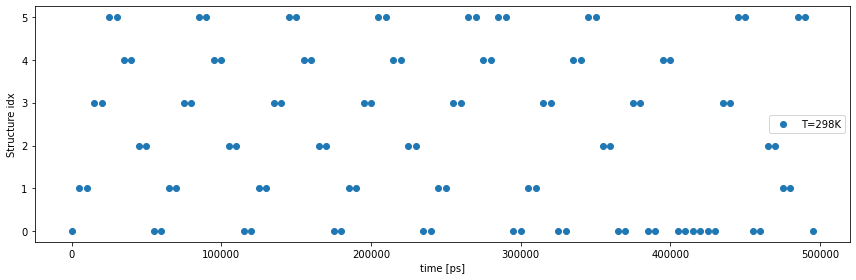

In [52]:
T_idx = 0  # choose different temperature here

fig, ax = plt.subplots(figsize=plt.figaspect(1./3))
ax.step(demux_temps[:, 0], demux_temps[:, T_idx+1], "o", 
         label="T={}K".format(temps[T_idx]), where="post")
ax.set(xlabel="time [ps]", ylabel="Structure idx")
ax.legend()
fig.tight_layout()

##  Structurally Continuous

Another interesting thing is how a certain structure is being exchanged. For temperature replica exchange simulation this will allow us to see how a structure passes through temperature space.

The demux tool can provide structurally continuous information with the `--structure_cont` switch.

In [53]:
!pycomplexes demux simulation-temp-298/config remc_demux_reps.csv --structure_cont --format=csv

Here we use an alternative output to *xvg* a *csv* (comma separated value) format that can be read using pandas.

In [54]:
demux_reps = pd.read_csv("remc_demux_reps.csv")

In the resulting *csv* the columns for each structure are called `repl-x`, with *x* being the index.

In [55]:
demux_reps.head()

,repl-0,repl-1,repl-2,repl-3,repl-4,repl-5,frame,time
0,0,1,2,3,4,5,0,0.0
1,1,0,3,2,5,4,5,5000.0
2,2,0,4,1,5,3,10,10000.0
3,3,1,5,0,4,2,15,15000.0
4,4,2,5,0,3,1,20,20000.0


You can visualize the walk through temperature space by plotting a selected column. Please note here that we update the yticks to represent the temperatures and not the id of the thermodynamic configuration.

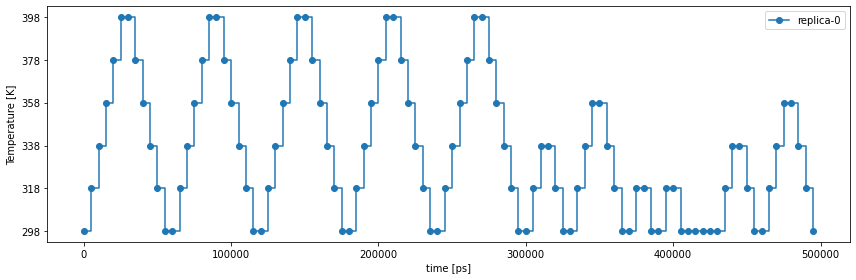

In [56]:
repl_idx = 0  # choose different replica here

fig, axs = plt.subplots(figsize=plt.figaspect(1./3))
axs.step(demux_reps["time"], demux_reps["repl-{}".format(repl_idx)],
         "o-",
         label="replica-{}".format(repl_idx), 
         where="post")
axs.set(xlabel="time [ps]", ylabel="Temperature [K]",
        yticks=range(len(temps)), yticklabels=temps)
axs.legend()
fig.tight_layout()